In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import random

In [ ]:
# tensorflow imports
from tensorflow import keras
from keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

Here import the file that contains the prepared data-set. As the experiment is not done under the the same time condition, we have to standardize the lengh data for each participant, just in that case the data-set can be used to train a LSTM. 
We set it to the smallest time series, it was 54 points(each point comes from the merge30 which is a data average of 30 seconds).  After pre processing it we have as a result that a dataset of 1836 points

In [ ]:
DatLSTM = pd.read_excel('DataLSTM_levels.xlsx')
DatLSTM = DatLSTM.dropna()
D_Lstm2 = DatLSTM.copy()
D_Lstm2 = D_Lstm2.drop(['Participant','stress',], axis = 1)
#invoices.drop(['client'], axis=1)
D_Lstm2.head()

,Unnamed: 0,HR,EDA,Temp,Label
0,5.0,72.987667,0.191197,35.878667,0.0
1,6.0,83.833000,0.222997,35.955333,0.0
2,7.0,87.537000,0.247216,36.054667,0.0
3,8.0,84.711667,0.262016,36.133000,0.0
4,9.0,92.909333,0.265123,36.176000,0.0


In [ ]:
#For traing the LSTM we will use class code.

n_tr, n_val = int(0.5885*len(DatLSTM)), int(0.2358*len(DatLSTM)) # Here traning set, val and test must be assiged to math with a 54 multiple
n_te = len(DatLSTM) - n_tr - n_val
print('Samples for training: %d; validation: %d; test: %d' % (n_tr, n_val, n_te))

Samples for training: 1080; validation: 432; test: 324


We use 20 participants data for training the LSTM, and 8 participants for validation and finally 6 participant data for validation.

In [ ]:
# Get the data from the dataframe (dropping date column)
data = D_Lstm2.iloc[:, 1:-1].values
print(data.shape)
# We need to normalise our time series. Calculate mean and std from TRAINING DATA ONLY. 
# We'll use it on the validation and test sets.
#data[:n_tr, :-1]
mean_tr = data[:n_tr, :].mean(axis=0)
std_tr = data[:n_tr, :].std(axis=0)
data[:, :] = (data[:, :] - mean_tr) / std_tr


y = D_Lstm2['Label'].values.reshape(-1, 1)

(1836, 3)


In [ ]:
data #verifing the normalization

array([[-0.76263195, -0.6829113 ,  1.88906902],
       [ 0.09211002, -0.66216974,  1.92301961],
       [ 0.38402952, -0.64637325,  1.96700777],
       ...,
       [ 0.54982361,  0.24097864,  0.28113947],
       [ 0.57795948,  0.3190474 ,  0.3130235 ],
       [ 0.02199364,  0.36974901,  0.33708414]])

In [ ]:
# We'll use a Dataset from keras to pass our data
sampling_rate = 1  # we keep all data points
sequence_length = 5  # 2.5 min to predict stress or not
delay = sampling_rate * sequence_length  # the target is the next step after the end of the sequence
batch_size = 54 

In [ ]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=0, end_index=n_tr  
    )

val_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=n_tr, end_index=n_tr+n_val  
    )

test_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=n_tr+n_val  
    )

for X, target in train_dataset:
    print("X shape:", X.shape)
    print("target shape:", target.shape)
    break  # so we only print once

X shape: (54, 5, 3)
target shape: (54, 1)


In [ ]:
#Here is time to define the model
model_lstm3 = models.Sequential()
model_lstm3.add(layers.LSTM(40, input_shape=(sequence_length, len(D_Lstm2.columns)-2)))
model_lstm3.add(layers.Dense(1))

model_lstm3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 40)                7040      
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
Total params: 7,081
Trainable params: 7,081
Non-trainable params: 0
_________________________________________________________________


In [ ]:
n_epochs = 40

In [ ]:
model_lstm3.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_lstm3 = model_lstm3.fit(train_dataset, epochs=n_epochs, validation_data=val_dataset)

Epoch 1/40
20/20 [==============================] - 3s 45ms/step - loss: 1.2427 - mae: 0.9806 - val_loss: 1.3757 - val_mae: 1.0393
Epoch 2/40
20/20 [==============================] - 0s 19ms/step - loss: 1.2207 - mae: 0.9728 - val_loss: 1.3792 - val_mae: 1.0402
Epoch 3/40
20/20 [==============================] - 0s 19ms/step - loss: 1.2170 - mae: 0.9702 - val_loss: 1.3808 - val_mae: 1.0405
Epoch 4/40
20/20 [==============================] - 0s 20ms/step - loss: 1.2133 - mae: 0.9677 - val_loss: 1.3823 - val_mae: 1.0408
Epoch 5/40
20/20 [==============================] - 0s 19ms/step - loss: 1.2097 - mae: 0.9653 - val_loss: 1.3840 - val_mae: 1.0410
Epoch 6/40
20/20 [==============================] - 0s 24ms/step - loss: 1.2060 - mae: 0.9629 - val_loss: 1.3859 - val_mae: 1.0412
Epoch 7/40
20/20 [==============================] - 0s 20ms/step - loss: 1.2023 - mae: 0.9607 - val_loss: 1.3878 - val_mae: 1.0414
Epoch 8/40
20/20 [==============================] - 0s 20ms/step - loss: 1.1987 - m

In [ ]:
#Store predicted results in results3
results3 = model_lstm3.predict(test_dataset) #40 cells

6/6 [==============================] - 1s 10ms/step


In [ ]:
#A model with less cells, just 20
model_lstm2 = models.Sequential()
model_lstm2.add(layers.LSTM(20, input_shape=(sequence_length, len(D_Lstm2.columns)-2)))
model_lstm2.add(layers.Dense(1))
model_lstm2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 20)                1920      
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,941
Trainable params: 1,941
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm2.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_lstm2 = model_lstm2.fit(train_dataset, epochs=n_epochs, validation_data=val_dataset)

Epoch 1/40
20/20 [==============================] - 3s 55ms/step - loss: 1.2424 - mae: 0.9856 - val_loss: 1.3331 - val_mae: 1.0306
Epoch 2/40
20/20 [==============================] - 1s 30ms/step - loss: 1.2285 - mae: 0.9807 - val_loss: 1.3322 - val_mae: 1.0294
Epoch 3/40
20/20 [==============================] - 1s 30ms/step - loss: 1.2259 - mae: 0.9790 - val_loss: 1.3318 - val_mae: 1.0287
Epoch 4/40
20/20 [==============================] - 0s 23ms/step - loss: 1.2233 - mae: 0.9774 - val_loss: 1.3317 - val_mae: 1.0279
Epoch 5/40
20/20 [==============================] - 1s 38ms/step - loss: 1.2209 - mae: 0.9759 - val_loss: 1.3315 - val_mae: 1.0272
Epoch 6/40
20/20 [==============================] - 0s 19ms/step - loss: 1.2184 - mae: 0.9744 - val_loss: 1.3315 - val_mae: 1.0265
Epoch 7/40
20/20 [==============================] - 0s 18ms/step - loss: 1.2160 - mae: 0.9730 - val_loss: 1.3314 - val_mae: 1.0258
Epoch 8/40
20/20 [==============================] - 0s 22ms/step - loss: 1.2135 - m

In [ ]:
#Storaging predicted data for second LSTM 
results2 = model_lstm2.predict(test_dataset) #LSTM 20Cells

6/6 [==============================] - 1s 14ms/step


**Using HR and T**

As we see in the previous analysis T is not a variable that had a low correlation, therefore we train a new model without T.


In [ ]:
DatLSTM = pd.read_excel('DataLSTM_levels.xlsx')
DatLSTM = DatLSTM.dropna()
D_Lstm3 = DatLSTM.copy()
D_Lstm3 = D_Lstm3.drop(['Participant','stress','Temp'], axis = 1)
#invoices.drop(['client'], axis=1)
D_Lstm3.head()

,Unnamed: 0,HR,EDA,Label
0,5.0,72.987667,0.191197,0.0
1,6.0,83.833000,0.222997,0.0
2,7.0,87.537000,0.247216,0.0
3,8.0,84.711667,0.262016,0.0
4,9.0,92.909333,0.265123,0.0


In [ ]:
# Get the data from the dataframe (dropping date column)
data = D_Lstm3.iloc[:, 1:-1].values
print(data.shape)

# We'll use it on the validation and test sets.
#data[:n_tr, :-1]
mean_tr = data[:n_tr, :].mean(axis=0)
std_tr = data[:n_tr, :].std(axis=0)
data[:, :] = (data[:, :] - mean_tr) / std_tr

y = D_Lstm3['Label'].values.reshape(-1, 1)


(1836, 2)


In [ ]:
model_lstm4 = models.Sequential()
model_lstm4.add(layers.LSTM(40, input_shape=(sequence_length, len(D_Lstm3.columns)-1)))
model_lstm4.add(layers.Dense(1))

model_lstm4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 40)                7040      
                                                                 
 dense_4 (Dense)             (None, 1)                 41        
                                                                 
Total params: 7,081
Trainable params: 7,081
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm4.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_lstm4 = model_lstm4.fit(train_dataset, epochs=n_epochs, validation_data=val_dataset)

Epoch 1/40
20/20 [==============================] - 3s 46ms/step - loss: 3.7042 - mae: 1.5694 - val_loss: 3.0353 - val_mae: 1.4272
Epoch 2/40
20/20 [==============================] - 0s 24ms/step - loss: 3.0908 - mae: 1.4422 - val_loss: 2.5609 - val_mae: 1.3182
Epoch 3/40
20/20 [==============================] - 0s 21ms/step - loss: 2.4919 - mae: 1.3094 - val_loss: 2.0453 - val_mae: 1.1732
Epoch 4/40
20/20 [==============================] - 0s 22ms/step - loss: 1.8844 - mae: 1.1462 - val_loss: 1.6164 - val_mae: 1.0900
Epoch 5/40
20/20 [==============================] - 0s 23ms/step - loss: 1.4993 - mae: 1.0781 - val_loss: 1.4418 - val_mae: 1.0809
Epoch 6/40
20/20 [==============================] - 1s 25ms/step - loss: 1.4152 - mae: 1.0671 - val_loss: 1.4140 - val_mae: 1.0757
Epoch 7/40
20/20 [==============================] - 1s 31ms/step - loss: 1.4014 - mae: 1.0617 - val_loss: 1.4097 - val_mae: 1.0743
Epoch 8/40
20/20 [==============================] - 1s 34ms/step - loss: 1.3906 - m

In [ ]:
results4 = model_lstm4.predict(test_dataset) #LSTM 40 cells HR+EDA

6/6 [==============================] - 1s 10ms/step


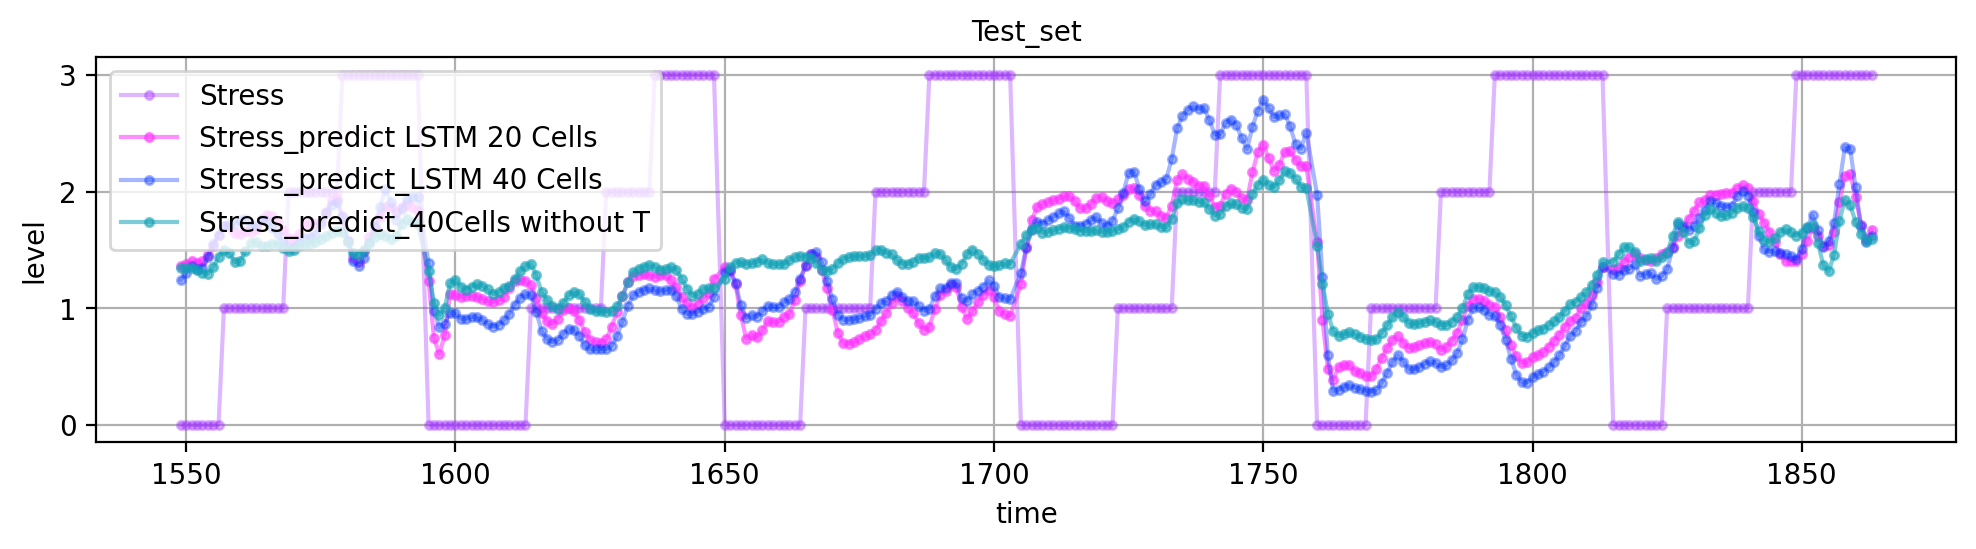

In [ ]:
#Plots to show the results from LSTM
x=D_Lstm2.index[1521:1831]
t=x.to_numpy()
stress = D_Lstm2.values[1521:1831].T[4]# stress now LABEL
plt.figure(figsize=(12,2.5), dpi=200)
plt.plot(t, stress,'.-',color="#A233FF",alpha=0.35,label="Stress")
plt.plot(t, results2[5:],'.-',color="#FD33FF",alpha=0.55,label="Stress_predict LSTM 20 Cells")
plt.plot(t, results3[5:],'.-',color="#0033FF",alpha=0.35,label="Stress_predict_LSTM 40 Cells")
plt.plot(t, results4[5:],'.-',color="#12A2B6",alpha=0.55,label="Stress_predict_40Cells without T")

plt.title("Test_set",fontsize=10)
plt.legend()
plt.xlabel("time")
plt.ylabel("level")
plt.grid('True')
plt.show()



In [ ]:
#Now is time to evaluate
#Our predict result are not integer data, so we use a loop to have a new vectors  with integer results
aux20 = []
for h in range(5,len(results2)):
  aux20.append(round(results2[h,0]))

aux40 = []
for h in range(5,len(results3)):
  aux40.append(round(results3[h,0]))

aux_T = []
for h in range(5,len(results4)):
  aux_T.append(round(results4[h,0]))

In [ ]:
print(len(aux_T))

310


In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

Here we evaluate models' accuracy, despite in the plot we can appreciate that our models try to follow the patern, we need to measure how good they are.

In [ ]:
print("Accuracy:",metrics.accuracy_score(stress, aux20))
print("Accuracy:",metrics.accuracy_score(stress, aux40))
print("Accuracy:",metrics.accuracy_score(stress, aux_T))

Accuracy: 0.21935483870967742
Accuracy: 0.2161290322580645
Accuracy: 0.22903225806451613


Poor performance! 😢 💔

In [ ]:
val_cross_T = pd.crosstab(stress, aux40)
val_cross_T

col_0,0,1,2,3
row_0,,,,
0.0,7,53,20,0
1.0,7,34,38,0
2.0,1,33,14,7
3.0,7,46,31,12


In [ ]:
# To model
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as score

In [ ]:
# Separating data
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
Dat = DatLSTM.replace({0: "Zero", 1: "Stress1", 2:"Stress2", 3:"Stress3"})
Dat.head()


,Unnamed: 0,Participant,HR,EDA,Temp,Label,stress
0,5.0,Stress2,72.987667,0.191197,35.878667,Zero,Zero
1,6.0,Stress2,83.833000,0.222997,35.955333,Zero,Zero
2,7.0,Stress2,87.537000,0.247216,36.054667,Zero,Zero
3,8.0,Stress2,84.711667,0.262016,36.133000,Zero,Zero
4,9.0,Stress2,92.909333,0.265123,36.176000,Zero,Zero


In [ ]:
X = Dat[['HR','EDA']]
y = Dat['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2645, random_state = 100)
print(len(y_test))

486


In [ ]:
forest = RandomForestClassifier(n_estimators=100, random_state = 100)
#Fitting models
forest.fit(X_train, y_train)
predictions = forest.predict(X_test)
# Evaluating the model
print("Accuracy:",metrics.accuracy_score(y_test, predictions))

Accuracy: 0.5082304526748971


In [ ]:
# Model train error
#-------------------------------------------------------------------------------
val_cross1 = pd.crosstab(y_train, forest.predict(X = X_train))
val_cross1

col_0,Stress1,Stress2,Stress3,Zero
Label,,,,
Stress1,326,0,0,0
Stress2,0,240,0,0
Stress3,0,0,440,0
Zero,0,0,0,344


In [ ]:
# Error de test for this model
#-------------------------------------------------------------------------------
val_cross2 = pd.crosstab(y_test, forest.predict(X = X_test))
val_cross2

col_0,Stress1,Stress2,Stress3,Zero
Label,,,,
Stress1,60,12,28,18
Stress2,12,29,31,14
Stress3,23,22,99,14
Zero,31,13,21,59
